In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
%matplotlib inline

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)
engine.dispose()

In [4]:
#Replace nan values with mean values by state
df2 = education_df.copy(deep=True)

states = education_df['STATE'].unique()
variables = ['ENROLL', 'TOTAL_REVENUE','FEDERAL_REVENUE', 'STATE_REVENUE', 
             'LOCAL_REVENUE','TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE', 
             'OTHER_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G','GRADES_4_G', 
             'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G','GRADES_9_12_G', 'GRADES_ALL_G']
        
for variable in variables:
    for state in states:
        df2.loc[df2['STATE'] == state, variable].fillna(df2[education_df['STATE'] == state][variable].mean(),inplace=True)

In [5]:
#Replace nan values with interpolated values by state/year

avg_variables = ['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']

for variable in avg_variables:
    for state in states:
        df2.loc[df2['STATE'] == state, variable] = df2.loc[df2['STATE'] == state, variable].interpolate(method='linear')

In [22]:
#Any states which still have NanN values should be dropped as they do not have sufficient data to accurately fill
df2 = df2.dropna()

# 1. Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

In [23]:
df2.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
54,1993_ARIZONA,ARIZONA,1993,676297.0,3427976.0,318465.0,1415407.0,1694104.0,3623946.0,1578889.0,...,57701.0,53500.0,37614.0,461398.0,182737.0,647299.0,215.834434,265.993417,206.291984,262.448330
55,1993_ARKANSAS,ARKANSAS,1993,311432.0,1346909.0,128196.0,771079.0,447634.0,1376067.0,782791.0,...,34255.0,36471.0,27169.0,280280.0,125801.0,407329.0,211.616130,257.647254,208.685273,266.423396
57,1993_COLORADO,COLORADO,1993,539538.0,3058326.0,147793.0,1242337.0,1668196.0,3028305.0,1537714.0,...,50807.0,47665.0,34770.0,403871.0,164260.0,575380.0,222.219036,273.200878,215.523979,266.856804
58,1993_CONNECTICUT,CONNECTICUT,1993,471918.0,4064158.0,149204.0,1433539.0,2481415.0,4079943.0,2302852.0,...,39093.0,34662.0,27979.0,310022.0,127655.0,443893.0,228.105503,275.202320,224.712775,264.457874
59,1993_DELAWARE,DELAWARE,1993,104355.0,683954.0,44497.0,443250.0,196207.0,694534.0,394680.0,...,8285.0,8265.0,5882.0,67899.0,28930.0,97394.0,217.181255,263.834857,207.792430,262.255809


In [116]:
df2['weighted_score'] = (((df2['AVG_MATH_4_SCORE'] + df2['AVG_READING_4_SCORE'])*0.5*df2['GRADES_4_G']) + 
                        ((df2['AVG_MATH_8_SCORE'] + df2['AVG_READING_8_SCORE'])*0.5*df2['GRADES_8_G']))/(df2['GRADES_8_G'] +
                                                                                                        df2['GRADES_4_G'])
                        

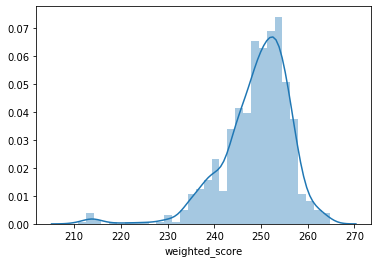

In [117]:
sns.distplot(df2['weighted_score'])
plt.show()

# 2. What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [41]:
df2.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE', 'weighted_score'],
      dtype='object')

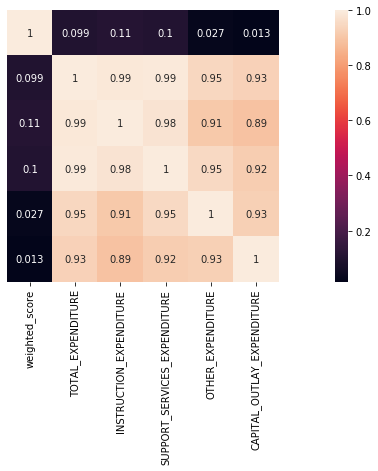

In [121]:
weighted_corr = df2.loc[:,('weighted_score','TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
                       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE')].corr()

plt.figure(figsize=(20,5))
sns.heatmap(weighted_corr,square=True,annot=True,yticklabels=False)
plt.show()

The variable with the strongest correlation to the weighted score is the OTHER_EXPENDITURE variable.

# 3. Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [78]:
#Create dataset and scale for PCA

X = df2.loc[:,('TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 
               'CAPITAL_OUTLAY_EXPENDITURE')]

sc = StandardScaler()
X = sc.fit_transform(X)

In [98]:
#Initialize pca, test 1st component

pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_[0])

0.9556304851603918


The first principal component captures ~95% of the variance in the data

# 4. What is the correlation between the overall score variable and the 1st principal component? 

In [90]:
#Initialize pca, save the 1st component in a variable, add into the dataframe

pca = PCA(n_components=1)
pc1 = pca.fit_transform(X)

df2['expenditure_pc1'] = pc1

In [122]:
df2.loc[:,('expenditure_pc1','weighted_score')].corr()

,expenditure_pc1,weighted_score
expenditure_pc1,1.000000,0.073271
weighted_score,0.073271,1.000000


# 5. If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

While the 1st principal component did not have a stronger correlation than the OTHER_EXPENDITURE variable, it captures 95% of the expenditure variance in just one variable and is correlated nearly as strongly. The specific question I was trying to answer would ultimately determine which variable I would include in the model.